# Classification Evaluation

## Import data

In [2]:
import os
import pcl
import numpy as np
import tqdm


"""
Data path
"""
data_path_wo_reg = os.path.abspath('../dataset/real_vehicle_data/object0_wo_registration/')
data_path_w_reg = os.path.abspath('../dataset/real_vehicle_data/object0_w_registration/')


"""
Import pcl data
"""

## without registration
data_wo_r = []

path_list = []
for root,d_names,f_names in os.walk(data_path_wo_reg):
    for f in f_names:
        
        if f.split(".")[-1] == 'pcd':
            path = os.path.join(root, f)
            path_list.append(path)
            
path_list.sort()

for p in tqdm.tqdm(path_list):
    pc = pcl.load(p)
    data_wo_r.append(pc)

## with registration
data_w_r = []

path_list = []
for root,d_names,f_names in os.walk(data_path_w_reg):
    for f in f_names:
        
        if f.split(".")[-1] == 'pcd':
            path = os.path.join(root, f)
            path_list.append(path)
            
path_list.sort()

for p in tqdm.tqdm(path_list):
    pc = pcl.load(p)
    data_w_r.append(pc)

    


100%|██████████| 896/896 [00:29<00:00, 29.94it/s]


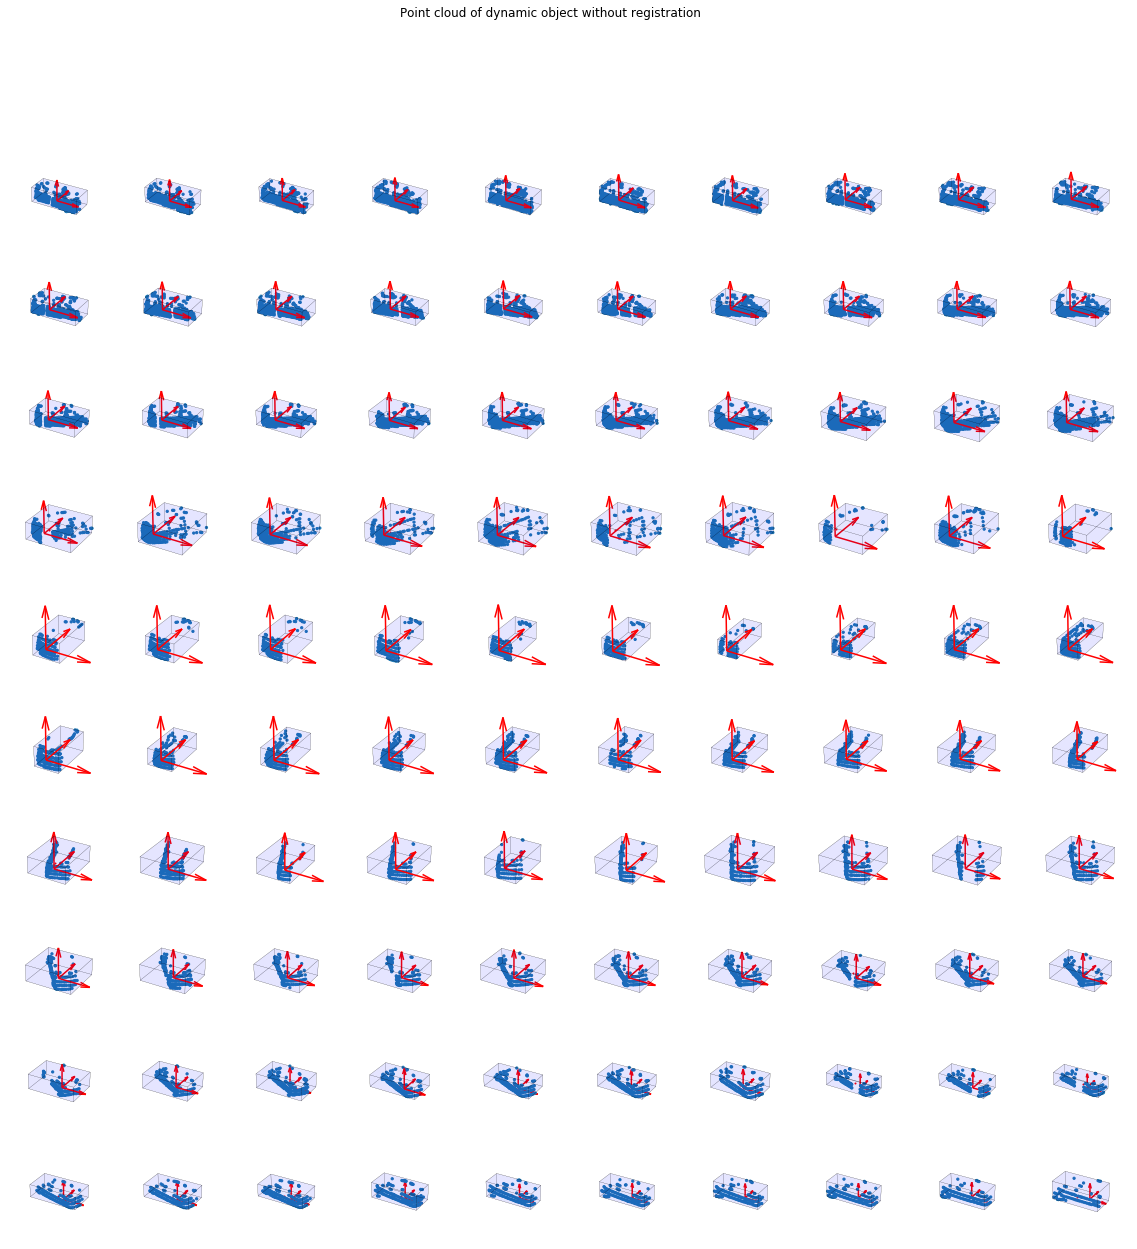

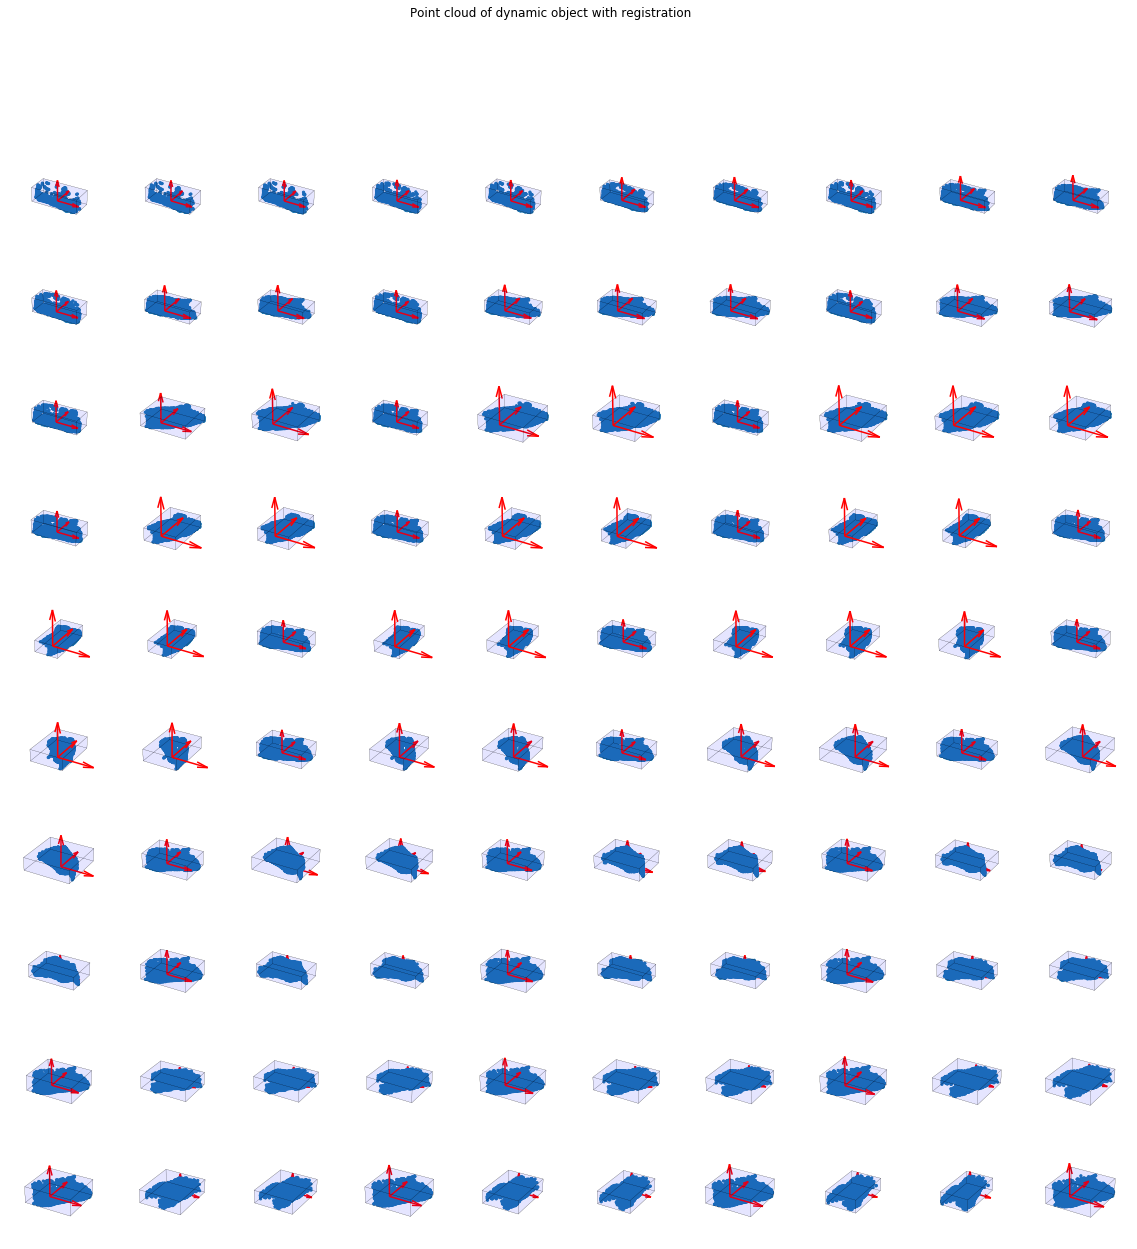

In [2]:
from visualization import *

%matplotlib inline
fig = plt.figure(figsize = (20,20))
fig.suptitle("Point cloud of dynamic object without registration")

for i in range(0,100):

    ax = fig.add_subplot(10,10,i+1, projection='3d')
    
    pc = np.asarray( data_wo_r[i] )
    display_point_cloud_box_ax_test(ax, pc)
    
    plt.axis('off')

plt.show()


fig = plt.figure(figsize = (20,20))
fig.suptitle("Point cloud of dynamic object with registration")

for i in range(0,100):

    ax = fig.add_subplot(10,10,i+1, projection='3d')
    
    pc = np.asarray( data_w_r[i] )
    display_point_cloud_box_ax_test(ax, pc)
    
    plt.axis('off')

plt.show()



## Classification results

In [3]:
import os, sys
import tensorflow as tf
import multiprocessing

""" 
Import model 
"""
sys.path.append( os.path.abspath('../../Network/model') )
from train import *
import model_out_5_heading as MODEL


model_path = os.path.abspath('../../Network/notebook/train_log_20181204/model_out5_4/model.ckpt')


# Data normalization and resampling
def NormalizeResample(data, num_sample):
    """ data is in N x ...
    we want to keep num_samplexC of them.
    if N > num_sample, we will randomly keep num_sample of them.
    if N < num_sample, we will randomly duplicate samples.
    """
  
    ## normalizing   
    x_min = float(data[:,0].min())
    x_max = float(data[:,0].max())
    y_min = float(data[:,1].min())
    y_max = float(data[:,1].max())
    z_min = float(data[:,2].min())
    z_max = float(data[:,2].max())
    
    scale_val = np.max([ x_max - x_min , y_max - y_min , z_max - z_min ])
    offset_val = np.min([x_min, y_min, z_min])
      
    data[:,0] = data[:,0] - offset_val
    data[:,1] = data[:,1] - offset_val
    data[:,2] = data[:,2] - offset_val
      
    data[:,0] = data[:,0] / float(scale_val)
    data[:,1] = data[:,1] / float(scale_val)
    data[:,2] = data[:,2] / float(scale_val)
                 
    ## resampling
    N = data.shape[0]
    if (N == num_sample):
        return data
    elif (N > num_sample):
        sample = np.random.choice(N, num_sample)
        return data[sample, ...]
    else:
        sample = np.random.choice(N, num_sample-N)
        dup_data = data[sample, ...]
        return np.concatenate([data, dup_data], 0)
    

results_list = []

def run_classification():
    
    global results_list
    
    is_training = False
    
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3
    BATCH_SIZE = 1

    # reset graph
    tf.reset_default_graph()

    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())

        # simple model
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
#         loss = MODEL.get_loss(pred, labels_pl, end_points)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = True

    ops = {'pointclouds_pl': pointclouds_pl,
           'is_training_pl': is_training_pl,
           'pred': pred}

    # ops.reset_default_graph() 

    sess = tf.Session(config=config)

    # Restore variables from disk.
    saver.restore(sess, model_path)

    print "Model restored"
    sys.stdout.flush()

    

    cd_list = []
    for d in data_w_r:
        d = np.asarray( d )
        cd = NormalizeResample(d, NUM_POINT)
        cd_list.append(cd)

    current_data = np.asarray(cd_list)

    current_label = np.array([0 for _ in range( current_data.shape[0] )])

    num_batches = current_data.shape[0] // BATCH_SIZE

    print "Number of total dataset / evaluated dataset: {} / {}".format(current_data.shape[0], num_batches * BATCH_SIZE)
    sys.stdout.flush()

    results = []

    for batch_idx in trange(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = (batch_idx+1) * BATCH_SIZE

        feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx].reshape((BATCH_SIZE, NUM_POINT, 3)),
                     ops['is_training_pl']: is_training}
        pred_val = sess.run([ops['pred']], feed_dict=feed_dict )

        pred_val = np.argmax(pred_val[0][:3], 1)
        results.append(pred_val)

    results_list.append(results)

# p = multiprocessing.Process(target=run_classification)
# p.start()
# p.join()

run_classification()

INFO:tensorflow:Restoring parameters from /media/kyungpyo/SmartCarContest/MasterThesisProject/Network/notebook/train_log_20181204/model_out5_4/model.ckpt
Model restored
Number of total dataset / evaluated dataset: 896 / 896


100%|██████████| 896/896 [00:34<00:00, 25.73it/s]


In [4]:
results_list

[[array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([1]),
  array([0]),
  array([1]),
  array([1]),
  array([0]),
  array([1]),
  array([1]),
  array([1]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([1]),
  array([0]),
  array([1]),
  array([1]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  array([0]),
  arra

In [ ]:
"""
Load data
"""



In [ ]:
import os, sys
import tensorflow as tf
import multiprocessing

""" 
Import model 
"""
sys.path.append( os.path.abspath('../../Network/model') )
from train import *
import model_out_5_heading as MODEL


model_path = os.path.abspath('../../Network/notebook/train_log_20181204/model_out5_4/model.ckpt')


# Data normalization and resampling
def NormalizeResample(data, num_sample):
    """ data is in N x ...
    we want to keep num_samplexC of them.
    if N > num_sample, we will randomly keep num_sample of them.
    if N < num_sample, we will randomly duplicate samples.
    """
  
    ## normalizing   
    x_min = float(data[:,0].min())
    x_max = float(data[:,0].max())
    y_min = float(data[:,1].min())
    y_max = float(data[:,1].max())
    z_min = float(data[:,2].min())
    z_max = float(data[:,2].max())
    
    scale_val = np.max([ x_max - x_min , y_max - y_min , z_max - z_min ])
    offset_val = np.min([x_min, y_min, z_min])
      
    data[:,0] = data[:,0] - offset_val
    data[:,1] = data[:,1] - offset_val
    data[:,2] = data[:,2] - offset_val
      
    data[:,0] = data[:,0] / float(scale_val)
    data[:,1] = data[:,1] / float(scale_val)
    data[:,2] = data[:,2] / float(scale_val)
                 
    ## resampling
    N = data.shape[0]
    if (N == num_sample):
        return data
    elif (N > num_sample):
        sample = np.random.choice(N, num_sample)
        return data[sample, ...]
    else:
        sample = np.random.choice(N, num_sample-N)
        dup_data = data[sample, ...]
        return np.concatenate([data, dup_data], 0)
    

results_list = []

def run_classification():
    
    global results_list
    
    is_training = False
    
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3
    BATCH_SIZE = 1

    # reset graph
    tf.reset_default_graph()

    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())

        # simple model
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
#         loss = MODEL.get_loss(pred, labels_pl, end_points)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = True

    ops = {'pointclouds_pl': pointclouds_pl,
           'is_training_pl': is_training_pl,
           'pred': pred}

    # ops.reset_default_graph() 

    sess = tf.Session(config=config)

    # Restore variables from disk.
    saver.restore(sess, model_path)

    print "Model restored"
    sys.stdout.flush()

    

    cd_list = []
    for d in data_wo_r:
        d = np.asarray( d )
        cd = NormalizeResample(d, NUM_POINT)
        cd_list.append(cd)

    current_data = np.asarray(cd_list)

    current_label = np.array([0 for _ in range( current_data.shape[0] )])

    num_batches = current_data.shape[0] // BATCH_SIZE

    print "Number of total dataset / evaluated dataset: {} / {}".format(current_data.shape[0], num_batches * BATCH_SIZE)
    sys.stdout.flush()

    results = []

    for batch_idx in trange(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = (batch_idx+1) * BATCH_SIZE

        feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx].reshape((BATCH_SIZE, NUM_POINT, 3)),
                     ops['is_training_pl']: is_training}
        pred_val = sess.run([ops['pred']], feed_dict=feed_dict )

        pred_val = np.argmax(pred_val[0][:3], 1)
        results.append(pred_val)

    results_list.append(results)

# p = multiprocessing.Process(target=run_classification)
# p.start()
# p.join()

run_classification()